# Import necessary modules:

In [3]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Search for all netcdf files in the working directory
This is just for the sake of automation for multiple files. There's probably better ways to do this. If you're just using one file, point the code to it.

In [4]:
nc_files = []
for file in os.listdir():
    if file.endswith('.nc'):
        nc_files.append(file)
print(nc_files)

['cams-europe-air-quality-forecasts-2022-07-22-2022-07-29.nc', 'T2M Hourly 2013-2021.nc', 'T2M Hourly 2022 Jan-May.nc', 'TP Monthly 2003 June.nc']


In [12]:
#Example of opening and naming different datasets with xarray 
dset1 = xr.open_dataset(nc_files[1])
dset2 = xr.open_dataset(nc_files[1])
dset3 = xr.open_dataset(nc_files[3])

dsets = [dset1, dset2, dset3]

In [13]:
#Preview the contents of dset2
dset2

<xarray.Dataset>
Dimensions:    (longitude: 53, latitude: 45, time: 78888)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.75 -10.5 -10.25 ... 1.5 1.75 2.0
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 2013-01-01 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-20 11:23:30 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

## The following code is used to show how close the dataset is in relation to given coordinates to a desired coordinate

In [98]:
#Set desired dataset as the "working" dataset for the code
dset = dset2

#Input coordinates of desired location (in this case, SPL or Leicester centre)
lat_in = 52.65
long_in = -1.13

#Obtaining the longitude and latitude values of the dataset
lat_vals = dset.coords['latitude'].values
long_vals = dset.coords['longitude'].values 

#Create a list of input coordinates, along with coordinates from the dataset
np.set_printoptions(suppress=True)
coord_in = [lat_in, long_in]
coord_vals = [lat_vals, long_vals]

nearest_coords = []
coord_indexes = []

#Scan over all coordinates from the dataset and find the nearest one to the desired input coordinate
for i in [0,1]:
    coord_len = np.ptp(coord_vals[i],axis=0)
    if coord_len == 359.75:
        coord_vals[i] = (coord_vals[i] - 180)
    position_coord = np.absolute(coord_in[i] - coord_vals[i][0])/coord_len
    points_coord = len(coord_vals[i])
    index_coord = int(np.round(position_coord*points_coord)) -1
    nearest_coord = coord_vals[i][index_coord]
    nearest_coords.append(nearest_coord)
    coord_indexes.append(index_coord)


print("Desired coords - " + str(coord_in))
print("Nearest Coords - " + str(nearest_coords))
print(coord_indexes)

Desired coords - [52.65, -1.13]
Nearest Coords - [52.75, -1.25]
[33, 39]


## Plot the resultant graph

(78888, 45, 53)


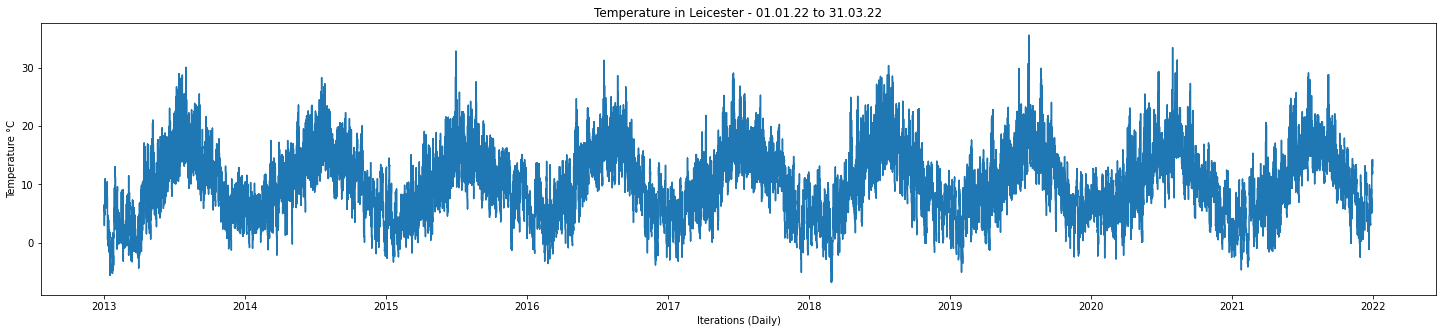

In [163]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

dset = dset2

#Obtain list of headers from dataset
var_name = list(dset.data_vars)[0]
dset_vals = dset[var_name].values

#Find out how many values are in the dataset
print(np.shape(dset_vals))
t_iterations = np.shape(dset_vals)[0]

#Get the temperature value in celcius for all values
t_list = []
for i in np.arange(0,t_iterations):
    t_list.append(dset_vals[i][coord_indexes[0]][coord_indexes[1]]-273.15) 

#Plot hourly value iterations
index_dates = []
for i in np.arange(len(t_list)):
    index_time = dset2.coords['time'].values[i]
    index_date = np.datetime_as_string(index_time, unit='D')
    index_dates.append(index_date)
index_dates = np.array(index_dates, dtype='datetime64')

plt.figure(figsize=(25,5))
plt.plot(index_dates, t_list)
plt.xlabel('Iterations (Daily)')
plt.ylabel('Temperature ' + u'\N{DEGREE SIGN}' + 'C')
plt.title('Temperature in Leicester - 01.01.22 to 31.03.22')
plt.show()

## Plot a 24 hour rolling mean to condense the plot

Text(0.5, 1.0, '24 hour rolling mean temperature in Leicester - 2013-01-01 to 2021-12-31')

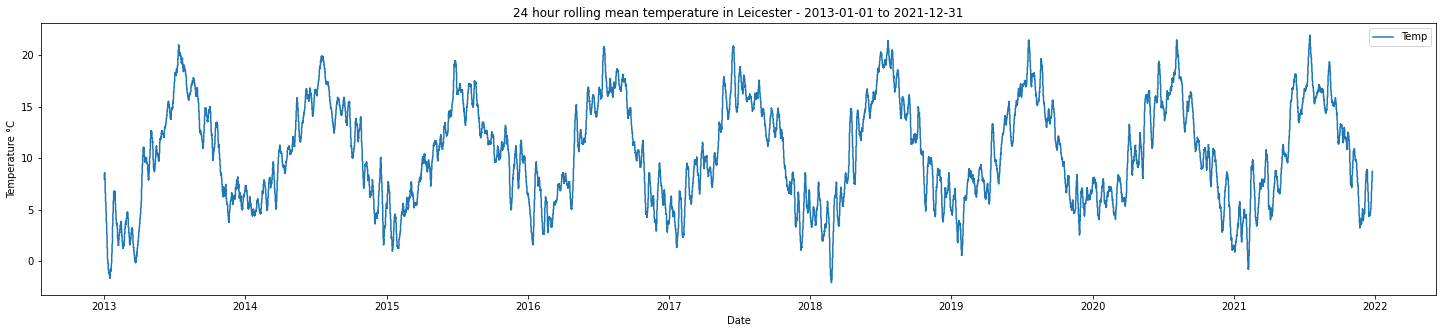

In [181]:
#Convert the list of strings to a datetime and .date will remove the time component
date_time = np.array(index_dates)
date_time = pd.to_datetime(date_time).date

#Put data into pandas dataframe
DF = pd.DataFrame({'Temp': (t_list)}, index=date_time)

start_date = date_time[0]
end_date = date_time[-1]

#Rolling average over 7 days 
n_days = 7
hours = 24
n = n_days*hours
def rolling_average(t_list, n) :
    ret = np.cumsum(t_list, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#Create rolling average dataframe
DF_rolling = pd.DataFrame({'Temp': rolling_average(t_list, n)}, index=date_time[:-n+1])
ax = DF_rolling.plot(x_compat=True, figsize=(25, 5))
plt.xlabel('Date')
plt.ylabel('Temperature ' + u'\N{DEGREE SIGN}' + 'C')
plt.title('24 hour rolling mean temperature in Leicester - ' + str(start_date) + ' to ' + str(end_date))
